In [37]:
# IMPORT SCIENTIFIC LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter1d

from neutronMS import MS_sim, GEN_constQgeom, E2k, k2E, Q2theta

%matplotlib inline
from IPython.display import clear_output

from IN8_read_data import gen_data_df_specJun24
from alias import *

## Load experimental geometry, $\mu_s$ and $\mu_abs$, and the $S(Q,\omega)$ data

### Experimental geometry

In [38]:
kf = 5.8

In [39]:
geom = ('anular', 1, 1.2, 6)

from numpy.random import rand
def ngen4rect_beam(N):
    dy_beam= geom[2]
    dz_beam=6
    x_init = -100
    return np.array([[x_init]*N, rand(N) * dy_beam - dy_beam/2, rand(N) * dz_beam - dz_beam/2]).T

from cross_sections import mu

###########
T = 300
###########

mu_s = lambda E: mu['gly'](E,T)
mu_abs = 0

### S(Q,$\omega$)

In [40]:
Qi_file = './data/MSdata/Sqw/Q_vec.npy'
omegaj_file = './data/MSdata/Sqw/omega_vec.npy'
Sij_file = {}
for T in [160,200,300]:
    Sij_file[T] = './data/MSdata/Sqw/Sqw_'+str(T)+'K.npy'

Text(0.5, 1.0, 'S(Q, $\\omega$) at 300K')

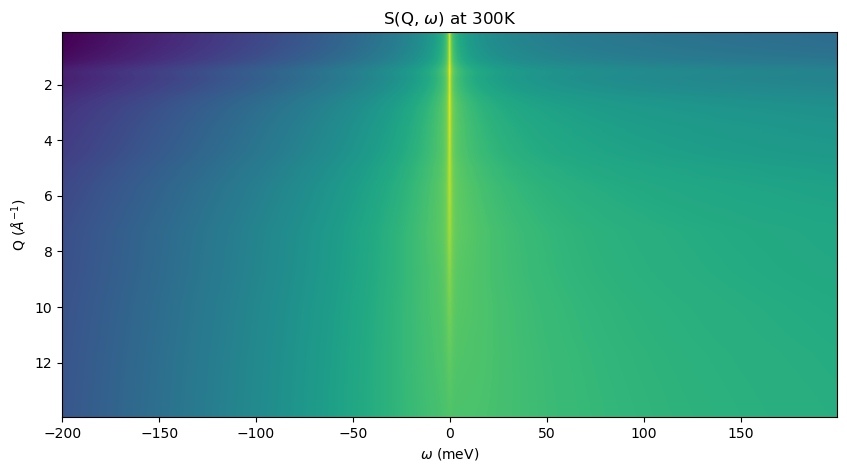

In [41]:
### Plot an example of S(Q, omega) at T

S_mash = np.load(Sij_file[T])
Qi = np.load(Qi_file)
omegaj = np.load(omegaj_file)

plt.figure(figsize=(10, 5))
plt.imshow(S_mash, aspect='auto',  extent=[omegaj[0], omegaj[-1], Qi[-1], Qi[0]], norm='log')
plt.ylabel('Q ($\AA^{-1}$)')
plt.xlabel('$\omega$ (meV)')
plt.title('S(Q, $\omega$) at '+str(T)+'K')

## Fixed $k_i$, $k_f$ and $\theta$ neutron story

In [42]:
############### INPUTS ###############
T = 300
Q = 1
omega = 0
######################################

# create inputs
S_files = (Sij_file[T], Qi_file, omegaj_file)
mus=(lambda E: mu['gly'](E,T), mu_abs)
ki = E2k(omega+k2E(kf))
theta = Q2theta(omega, kf, Q)

print('ki =', ki)
print('theta =', theta, 'rad')

ki = 5.8
theta = 0.17262806300607647 rad


In [43]:
# RUN the simulation
sim = MS_sim(geom, mus, S_files, ki, kf, theta)
sim.run(N=100000, B=5)
print('Is =', sim.Is)
print('Im/Is =', sim.Im/sim.Is)
print('T_self = ', sim.T_self)

Is = 3.0409118862459306e-08
Im/Is = 0.026250849446732814
T_self =  0.7392028104186583


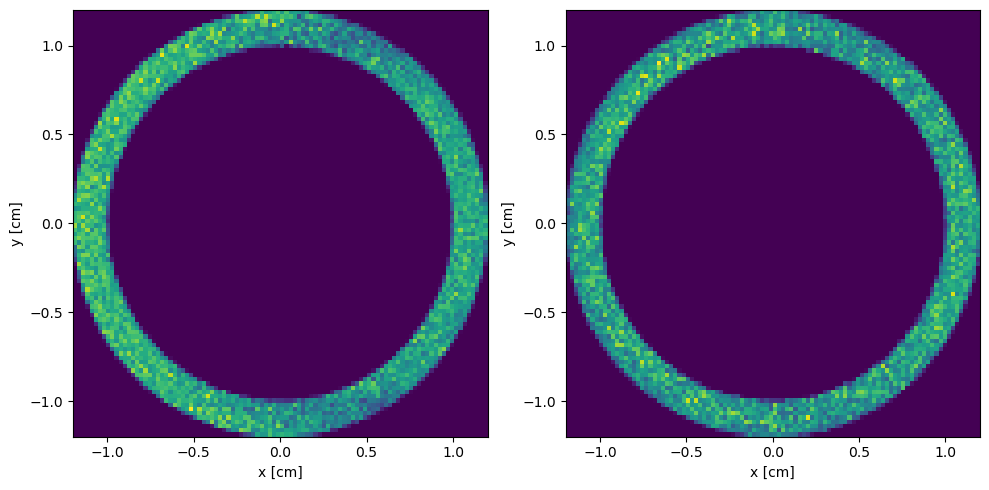

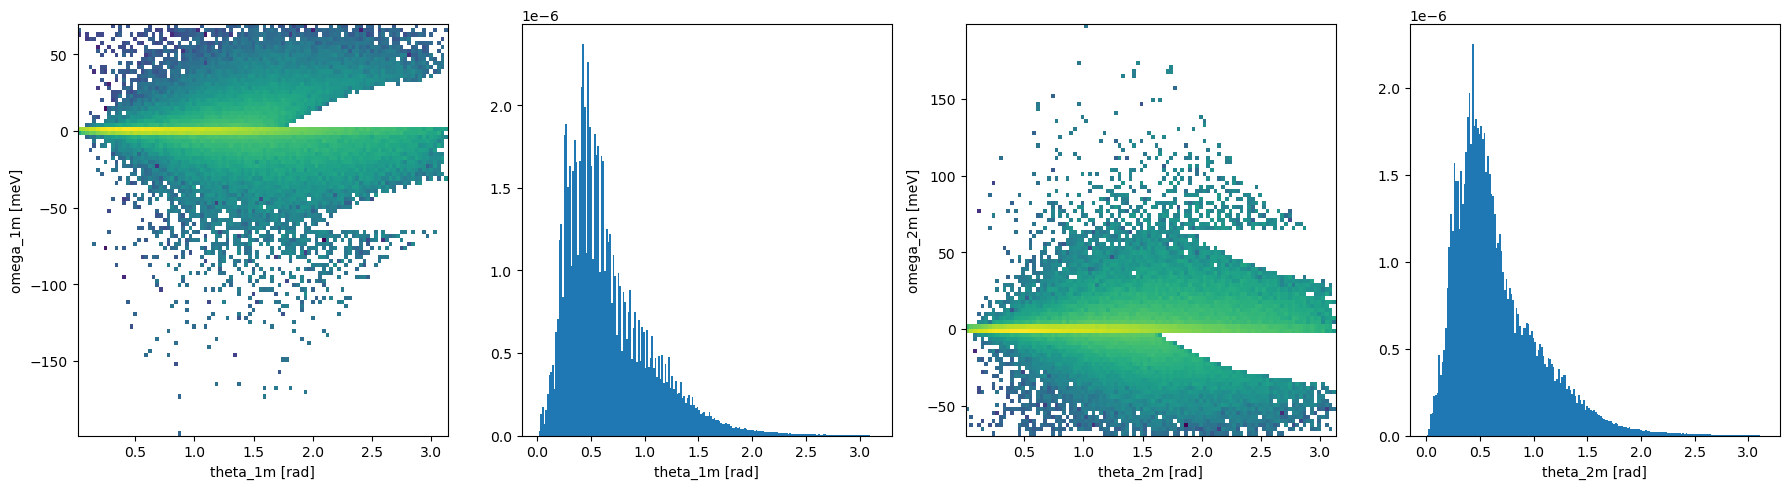

In [44]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.hist2d(sim.p1[:,0], sim.p1[:,1], bins=100, weights=sim.w1)
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.subplot(122)
plt.hist2d(sim.p2[:,0], sim.p2[:,1], bins=100, weights=sim.w2)
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
plt.tight_layout()

plt.figure(figsize=(18, 5))
plt.subplot(141)
plt.hist2d(sim.theta1m, sim.omega1m, weights=sim.wfm, norm='log', bins=100);
plt.xlabel('theta_1m [rad]')
plt.ylabel('omega_1m [meV]')
plt.subplot(142)
plt.hist(sim.theta1m, weights=sim.wfm, bins=200);
plt.xlabel('theta_1m [rad]')
plt.subplot(143)
plt.hist2d(sim.theta2m, sim.omega2m, weights=sim.wfm, norm='log', bins=100);
plt.xlabel('theta_2m [rad]')
plt.ylabel('omega_2m [meV]')
plt.subplot(144)
plt.hist(sim.theta2m, weights=sim.wfm, bins=200);
plt.xlabel('theta_2m [rad]')
plt.tight_layout()


## Constant Q multiple scattering spectrum

In [50]:
############### INPUTS ###############
T = 300
Q = 0.5
######################################

# create inputs
omega = np.arange(-40, 40, 0.1)
S_files = (Sij_file[T], Qi_file, omegaj_file)
mus=(lambda E: mu['gly'](E,T), mu_abs)

# generate dataframe with the configuration
dataMS = GEN_constQgeom('inverse', ki, Q, omega)
dataMS.dropna(inplace=True)
dataMS.reset_index(drop=True, inplace=True)

In [51]:
# drop raws with nan values
dataMS = dataMS.dropna()
for i in dataMS.index:
    # print progress
    clear_output()
    print('point', i+1, '/', dataMS.shape[0])
    print('simulating Q =', str(Q)+'A, E =', str(round(dataMS.loc[i, 'omega'], 3))+'meV .....')

    # create simulation and run
    sim = MS_sim(geom, mus, S_files, dataMS.ki.loc[i], dataMS.kf.loc[i], dataMS.theta.loc[i])
    sim.run(N=10000, B=5)

    # save results
    dataMS.loc[i,'Is'] = sim.Is
    dataMS.loc[i,'Im'] = sim.Im
    dataMS.loc[i,'T_self'] = sim.T_self

point 240 / 240
simulating Q = 0.5A, E = 12.5meV .....


Text(0, 0.5, 'T_self')

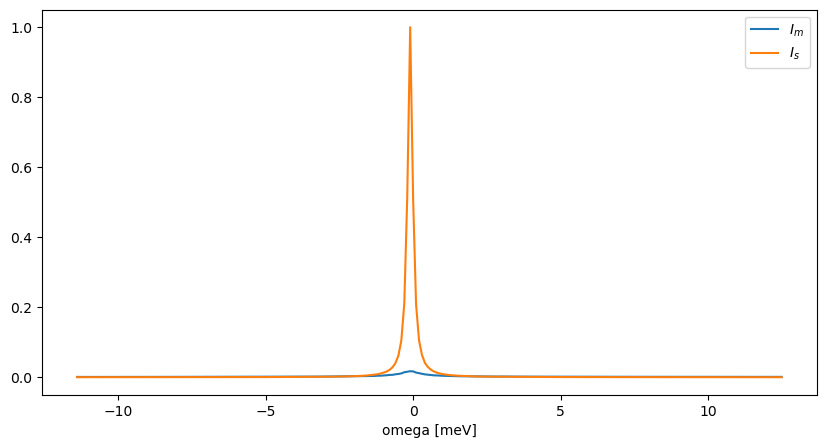

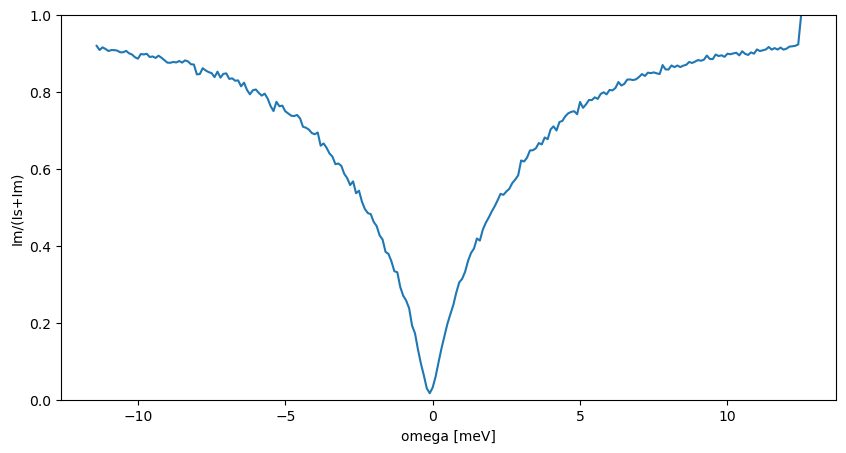

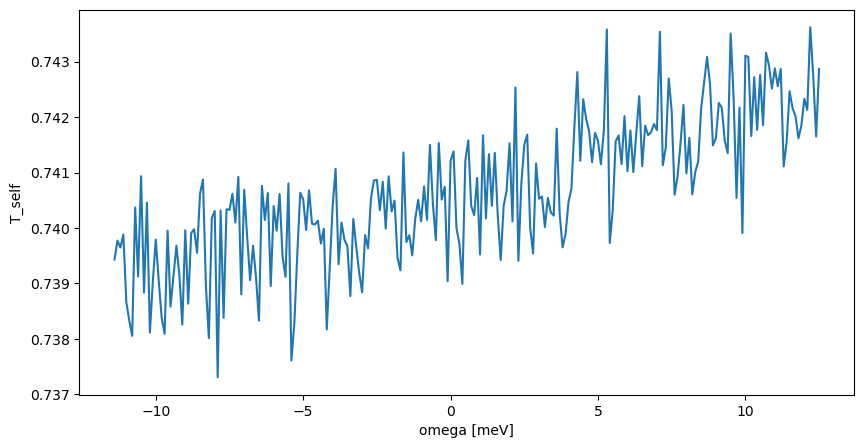

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(dataMS.omega, dataMS.Im/dataMS.Is.max(), label='$I_m$')
plt.plot(dataMS.omega, dataMS.Is/dataMS.Is.max(), label='$I_s$')
plt.xlabel('omega [meV]')
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(dataMS.omega, dataMS.Im/(dataMS.Is+dataMS.Im))
plt.xlabel('omega [meV]')
plt.ylabel('Im/(Is+Im)')

plt.ylim(0, 1)

plt.figure(figsize=(10, 5))
plt.plot(dataMS.omega, dataMS.T_self)
plt.xlabel('omega [meV]')
plt.ylabel('T_self')

#plt.ylim(0, 1)

## Multiple Q multiple scattering

In [55]:
Q = [.5, .7, .9, 1.1, 1.5]

MSdata = {}
for T in [160, 200, 300]:
    MSdata[T] = pd.concat([GEN_constQgeom('direct', ki, q, np.arange(-40, 40, 0.1)) for q in Q])
    MSdata[T].dropna(inplace=True)
    MSdata[T].reset_index(drop=True, inplace=True)

In [56]:
aut = input('Are you shure you whant to rerun the entire simulation (type yes)?')
if aut=='yes':
    for T in [160, 200, 300]:
        mus=(lambda E: mu['gly'](E,T), mu_abs)
        S_files = (Sij_file[T], Qi_file, omegaj_file)

        for i in MSdata[T].index:
            # print progress
            clear_output()
            print('T =', T, 'K', 'of', [160, 200, 300])
            print('point', i+1, '/', MSdata[T].shape[0])
            print('simulating Q =', str(MSdata[T].loc[i].Q)+'A, E =', str(round(MSdata[T].loc[i].omega, 3))+'meV .....')

            # create simulation and run
            sim = MS_sim(geom, mus, S_files, MSdata[T].ki.loc[i], MSdata[T].kf.loc[i], MSdata[T].theta.loc[i])
            sim.run(N=10000, B=5)


            # save results
            MSdata[T].loc[i,'Is'] = sim.Is
            MSdata[T].loc[i,'Im'] = sim.Im
            MSdata[T].loc[i,'T_self'] = sim.T_self

        MSdata[T].to_csv('./data/MSdata/simdata/simdata_'+str(T)+'K.csv', index=False)

T = 300 K of [160, 200, 300]
point 2253 / 2253
simulating Q = 1.5A, E = 31.3meV .....


## Comparison with test models

In [58]:
T = 300
Sij_file_test1 = {}
Sij_file_test1[T] = './data/MSdata/Sqw/Sqw_'+str(T)+'K_test1.npy'

Sij_file_test2 = {}
Sij_file_test2[T] = './data/MSdata/Sqw/Sqw_'+str(T)+'K_test2.npy'

Sij_file_test3 = {}
Sij_file_test3[T] = './data/MSdata/Sqw/Sqw_'+str(T)+'K_test3.npy'

Sij_file_test4 = {}
Sij_file_test4[T] = './data/MSdata/Sqw/Sqw_'+str(T)+'K_test4.npy'

In [59]:
############### INPUTS ###############
T = 300
Q = 1.1
######################################

# create inputs
omega = np.arange(-30,30,1)
mus=(lambda E: mu['gly'](E,T), mu_abs)

In [60]:
S_files = (Sij_file[T], Qi_file, omegaj_file)
dataMS = GEN_constQgeom('inverse', kf, Q, omega)
dataMS.dropna(inplace=True)
dataMS.reset_index(drop=True, inplace=True)

In [61]:
S_files_test1 = (Sij_file_test1[T], Qi_file, omegaj_file)
dataMS_test1 = GEN_constQgeom('inverse', kf, Q, omega)
dataMS_test1.dropna(inplace=True)
dataMS_test1.reset_index(drop=True, inplace=True)

In [62]:
S_files_test2 = (Sij_file_test2[T], Qi_file, omegaj_file)
dataMS_test2 = GEN_constQgeom('inverse', kf, Q, omega)
dataMS_test2.dropna(inplace=True)
dataMS_test2.reset_index(drop=True, inplace=True)

In [63]:
S_files_test3 = (Sij_file_test3[T], Qi_file, omegaj_file)
dataMS_test3 = GEN_constQgeom('inverse', kf, Q, omega)
dataMS_test3.dropna(inplace=True)
dataMS_test3.reset_index(drop=True, inplace=True)

In [64]:
S_files_test4 = (Sij_file_test4[T], Qi_file, omegaj_file)
dataMS_test4 = GEN_constQgeom('inverse', kf, Q, omega)
dataMS_test4.dropna(inplace=True)
dataMS_test4.reset_index(drop=True, inplace=True)

In [65]:
for i in dataMS.index:
    # print progress
    clear_output()
    print('point', i+1, '/', dataMS.shape[0])
    print('simulating Q =', str(Q)+'A, E =', str(round(dataMS.loc[i, 'omega'], 3))+'meV .....')

    # create simulation and run
    sim = MS_sim(geom, mus, S_files, dataMS.ki.loc[i], dataMS.kf.loc[i], dataMS.theta.loc[i])
    sim.run(N=10000, B=5)

    # save results
    dataMS.loc[i,'Is'] = sim.Is
    dataMS.loc[i,'Im'] = sim.Im

point 52 / 52
simulating Q = 1.1A, E = 28meV .....


In [66]:
for i in dataMS_test1.index:
    # print progress
    clear_output()
    print('point', i+1, '/', dataMS_test1.shape[0])
    print('simulating Q =', str(Q)+'A, E =', str(round(dataMS_test1.loc[i, 'omega'], 3))+'meV .....')

    # create simulation and run
    sim = MS_sim(geom, mus, S_files_test1, dataMS_test1.ki.loc[i], dataMS_test1.kf.loc[i], dataMS_test1.theta.loc[i])
    sim.run(N=10000, B=5)

    # save results
    dataMS_test1.loc[i,'Is'] = sim.Is
    dataMS_test1.loc[i,'Im'] = sim.Im

point 52 / 52
simulating Q = 1.1A, E = 28meV .....


In [67]:
for i in dataMS_test2.index:
    # print progress
    clear_output()
    print('point', i+1, '/', dataMS_test2.shape[0])
    print('simulating Q =', str(Q)+'A, E =', str(round(dataMS_test2.loc[i, 'omega'], 3))+'meV .....')

    # create simulation and run
    sim = MS_sim(geom, mus, S_files_test2, dataMS_test2.ki.loc[i], dataMS_test2.kf.loc[i], dataMS_test2.theta.loc[i])
    sim.run(N=10000, B=5)

    # save results
    dataMS_test2.loc[i,'Is'] = sim.Is
    dataMS_test2.loc[i,'Im'] = sim.Im

point 52 / 52
simulating Q = 1.1A, E = 28meV .....


In [68]:
for i in dataMS_test3.index:
    # print progress
    clear_output()
    print('point', i+1, '/', dataMS_test3.shape[0])
    print('simulating Q =', str(Q)+'A, E =', str(round(dataMS_test3.loc[i, 'omega'], 3))+'meV .....')

    # create simulation and run
    sim = MS_sim(geom, mus, S_files_test3, dataMS_test3.ki.loc[i], dataMS_test3.kf.loc[i], dataMS_test3.theta.loc[i])
    sim.run(N=10000, B=5)

    # save results
    dataMS_test3.loc[i,'Is'] = sim.Is
    dataMS_test3.loc[i,'Im'] = sim.Im

point 52 / 52
simulating Q = 1.1A, E = 28meV .....


In [69]:
for i in dataMS_test4.index:
    # print progress
    clear_output()
    print('point', i+1, '/', dataMS_test4.shape[0])
    print('simulating Q =', str(Q)+'A, E =', str(round(dataMS_test4.loc[i, 'omega'], 3))+'meV .....')

    # create simulation and run
    sim = MS_sim(geom, mus, S_files_test4, dataMS_test4.ki.loc[i], dataMS_test4.kf.loc[i], dataMS_test4.theta.loc[i])
    sim.run(N=10000, B=5)

    # save results
    dataMS_test4.loc[i,'Is'] = sim.Is
    dataMS_test4.loc[i,'Im'] = sim.Im

point 52 / 52
simulating Q = 1.1A, E = 28meV .....


In [70]:
domega_sim = dataMS.omega.iloc[1]-dataMS.omega.iloc[0]
domega_sim_test1 = dataMS_test1.omega.iloc[1]-dataMS_test1.omega.iloc[0]
domega_sim_test2 = dataMS_test2.omega.iloc[1]-dataMS_test2.omega.iloc[0]
domega_sim_test3 = dataMS_test3.omega.iloc[1]-dataMS_test3.omega.iloc[0]
domega_sim_test4 = dataMS_test4.omega.iloc[1]-dataMS_test4.omega.iloc[0]

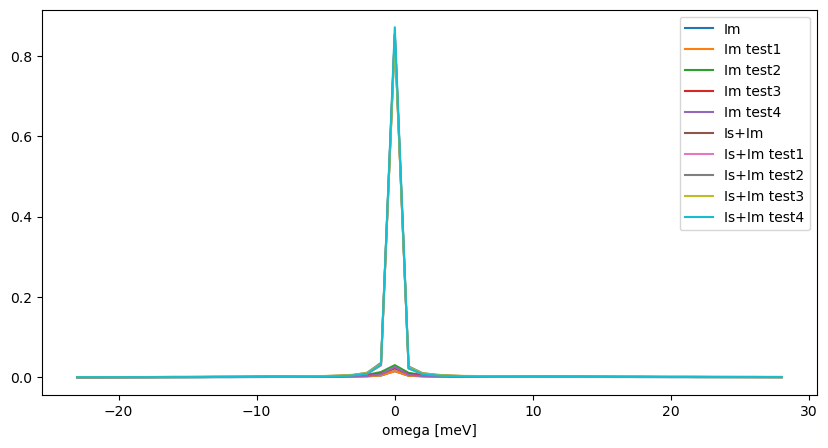

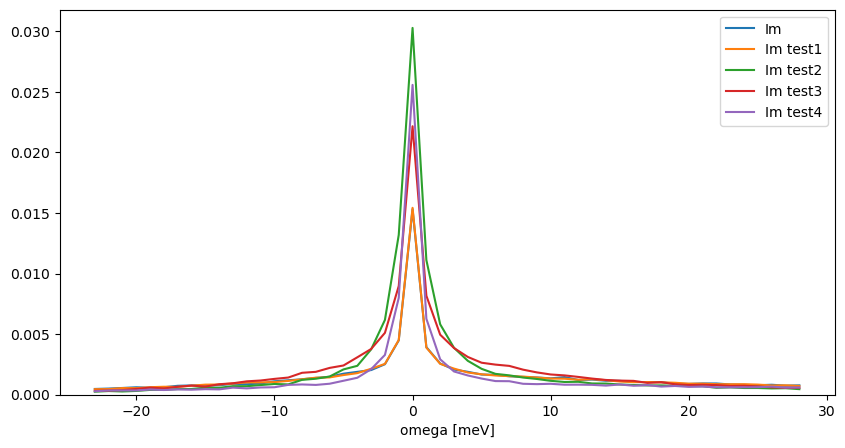

In [71]:
plt.figure(figsize=(10, 5))

plt.plot(dataMS.omega, dataMS.Im/(((dataMS.Is+dataMS.Im)).sum()*domega_sim), label='Im')
plt.plot(dataMS_test1.omega, dataMS_test1.Im/(((dataMS_test1.Is+dataMS_test1.Im)).sum()*domega_sim_test1), label='Im test1')
plt.plot(dataMS_test2.omega, dataMS_test2.Im/(((dataMS_test2.Is+dataMS_test2.Im)).sum()*domega_sim_test2), label='Im test2')
plt.plot(dataMS_test3.omega, dataMS_test3.Im/(((dataMS_test3.Is+dataMS_test3.Im)).sum()*domega_sim_test3), label='Im test3')
plt.plot(dataMS_test4.omega, dataMS_test4.Im/(((dataMS_test4.Is+dataMS_test4.Im)).sum()*domega_sim_test4), label='Im test4')

plt.plot(dataMS.omega, (dataMS.Im+dataMS.Is)/(((dataMS.Is+dataMS.Im)).sum()*domega_sim), label='Is+Im')
plt.plot(dataMS_test1.omega, (dataMS_test1.Is+dataMS_test1.Im)/(((dataMS_test1.Is+dataMS_test1.Im)).sum()*domega_sim_test1), label='Is+Im test1')
plt.plot(dataMS_test2.omega, (dataMS_test2.Is+dataMS_test2.Im)/(((dataMS_test2.Is+dataMS_test2.Im)).sum()*domega_sim_test2), label='Is+Im test2')
plt.plot(dataMS_test3.omega, (dataMS_test3.Is+dataMS_test3.Im)/(((dataMS_test3.Is+dataMS_test3.Im)).sum()*domega_sim_test3), label='Is+Im test3')
plt.plot(dataMS_test4.omega, (dataMS_test4.Is+dataMS_test4.Im)/(((dataMS_test4.Is+dataMS_test4.Im)).sum()*domega_sim_test4), label='Is+Im test4')

plt.xlabel('omega [meV]')
plt.legend()
#plt.ylim(0,0.03)


plt.figure(figsize=(10, 5))
plt.plot(dataMS.omega, dataMS.Im/(((dataMS.Is+dataMS.Im)).sum()*domega_sim), label='Im')
plt.plot(dataMS_test1.omega, dataMS_test1.Im/(((dataMS_test1.Is+dataMS_test1.Im)).sum()*domega_sim_test1), label='Im test1')
plt.plot(dataMS_test2.omega, dataMS_test2.Im/(((dataMS_test2.Is+dataMS_test2.Im)).sum()*domega_sim_test2), label='Im test2')
plt.plot(dataMS_test3.omega, dataMS_test3.Im/(((dataMS_test3.Is+dataMS_test3.Im)).sum()*domega_sim_test3), label='Im test3')
plt.plot(dataMS_test4.omega, dataMS_test4.Im/(((dataMS_test4.Is+dataMS_test4.Im)).sum()*domega_sim_test4), label='Im test4')

plt.xlabel('omega [meV]')
plt.ylim(0)
plt.legend()